In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

In [6]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier

In [7]:
from imblearn.under_sampling import RandomUnderSampler
!pip install category_encoders
from category_encoders import LeaveOneOutEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import reciprocal, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, r2_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 944.4 kB/s eta 0:00:00


In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv("/content/drive/MyDrive/heart_statlog_cleveland_hungary_final.csv")
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [10]:
print(df.columns)

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')


In [11]:
#check dublicates values
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  918 non-null    int64  
 1   sex                  918 non-null    int64  
 2   chest pain type      918 non-null    int64  
 3   resting bp s         918 non-null    int64  
 4   cholesterol          918 non-null    int64  
 5   fasting blood sugar  918 non-null    int64  
 6   resting ecg          918 non-null    int64  
 7   max heart rate       918 non-null    int64  
 8   exercise angina      918 non-null    int64  
 9   oldpeak              918 non-null    float64
 10  ST slope             918 non-null    int64  
 11  target               918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


In [12]:
cat_cols = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope', 'target']

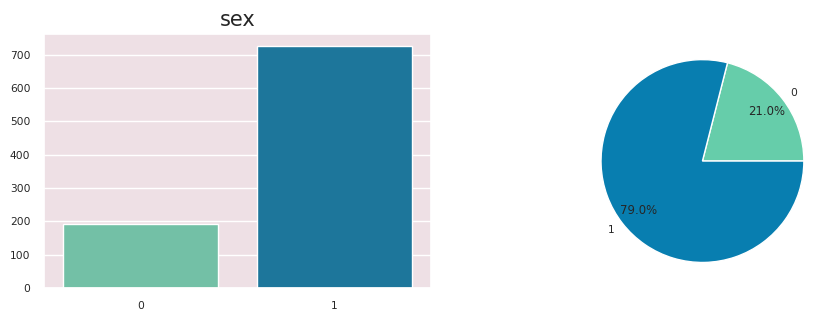

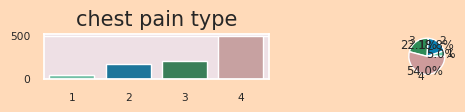

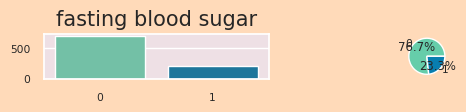

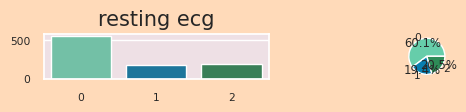

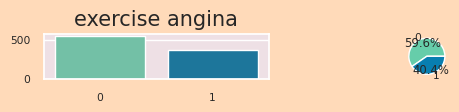

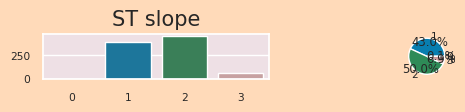

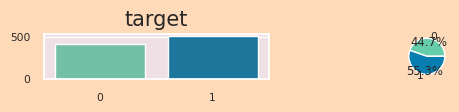

In [13]:
plt.figure(figsize=(11,27))
sns.set(rc={'axes.facecolor':'#eee0e5', 'figure.facecolor':'#ffdab9'}, font_scale=0.7)
clr1 = ["#66cdaa", "#087EB0", "#2e8b57", "#cd9b9b"]
i = 0
j = 1
for col in cat_cols:
  feature = df.groupby(col)[col].count()
  plt.subplot(7, 2, i+1)
  sns.barplot(x=feature.index, y=feature.values, palette=clr1)
  plt.title(col, fontsize=15)
  plt.xlabel("")
  plt.subplot(7, 2, j+1)
  plt.pie(x=feature.values, autopct="%.1f%%", pctdistance=0.8, labels=feature.index, colors=["#66cdaa", "#087EB0", "#2e8b57", "#cd9b9b"])
  i += 2
  j += 2
  plt.show()

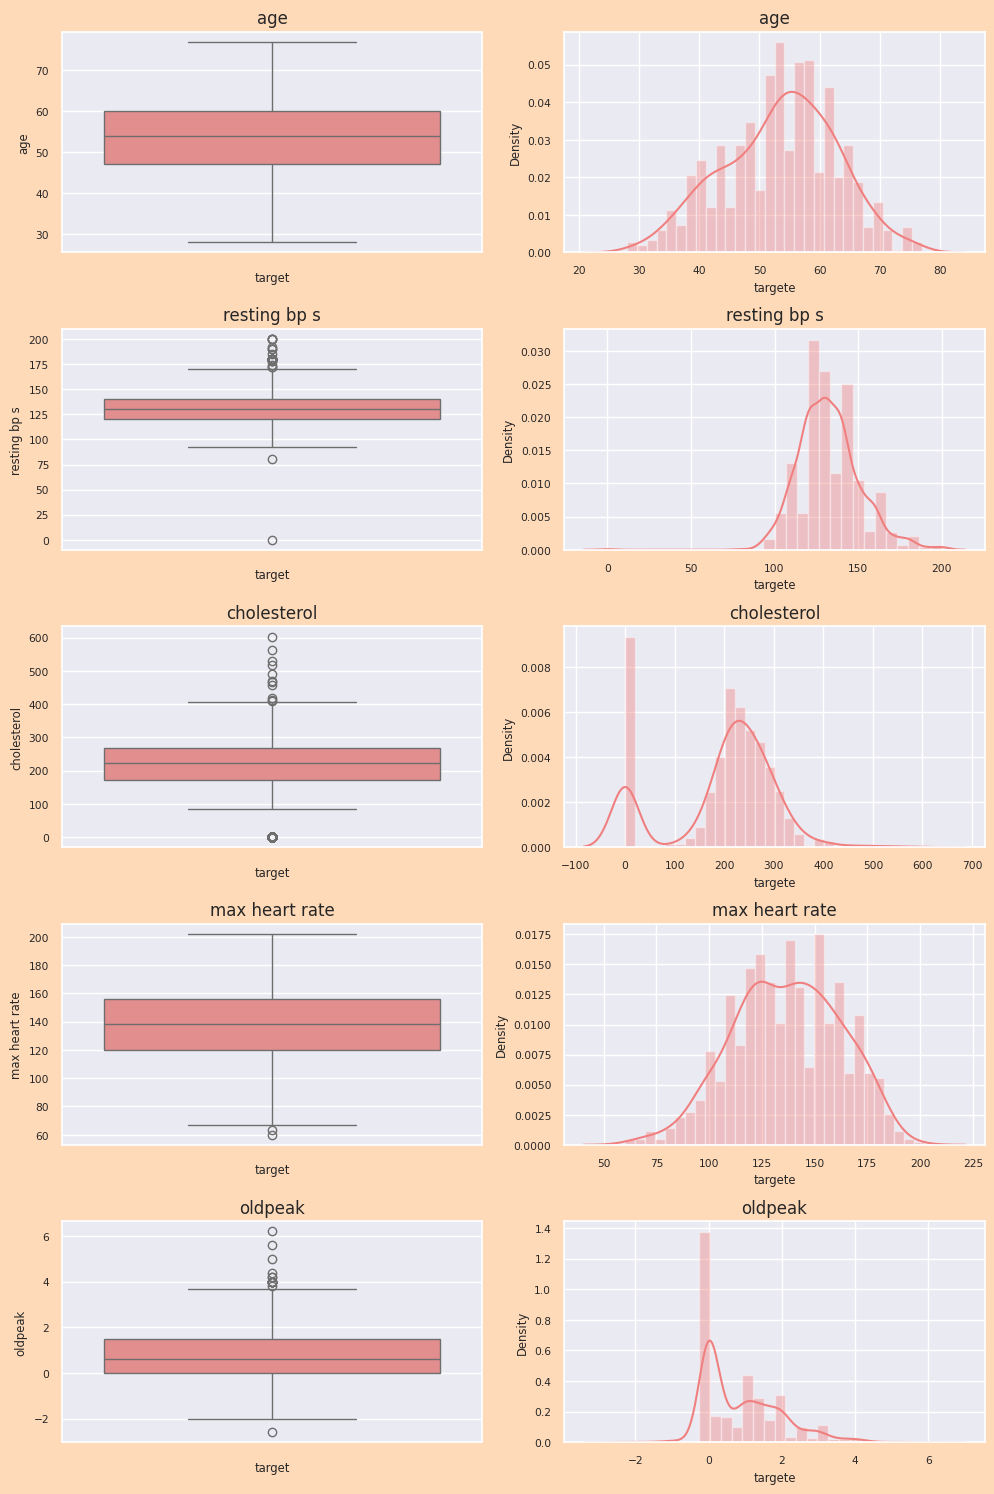

In [14]:
num_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
plt.figure(figsize=(10,15))
sns.set(font_scale=0.7)
i=0
j=0
for col in num_cols:
 plt.subplot(5, 2, i+1)
 sns.boxplot(df[col], color="#f08080")
 plt.title(col, fontsize=12)
 plt.xlabel("target")
 plt.subplot(5, 2, j+2)
 sns.distplot(df[col], bins=30, color="#f08080")
 plt.title(col, fontsize=12)
 plt.xlabel("targete")
 i += 2
 j += 2
plt.tight_layout()
plt.show()

In [15]:
#Outliers We will eliminate rows that have outliers in more than one variable
outlier_list = []
for i in num_cols:
    # Check if column exists in DataFrame
    if i in df.columns:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3-Q1
        outlier_step = IQR * 1.5
        index_list = df[(df[i] < Q1 - outlier_step) | (df[i] > Q3 + outlier_step)].index
        outlier_list.extend(index_list)
    else:
        print(f"Warning: Column '{i}' not found in DataFrame.")

outlier_list = Counter(outlier_list)
outlier_list = list(outlier_list.items())
multi_out_list = [key for key, value in outlier_list if value > 1]

In [16]:
print(f"Total number of rows with outliers: {len(outlier_list)}")
print(f"Number of rows with outliers in more than one variable :{len(multi_out_list)}")

Total number of rows with outliers: 216
Number of rows with outliers in more than one variable :13


In [17]:
df.drop(multi_out_list, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [18]:
#Relationship of one feature of data set with other
heart_diase_corr = df.corr()["target"]
heart_diase_corr = heart_diase_corr.drop("target", axis=0).sort_values(ascending=False)

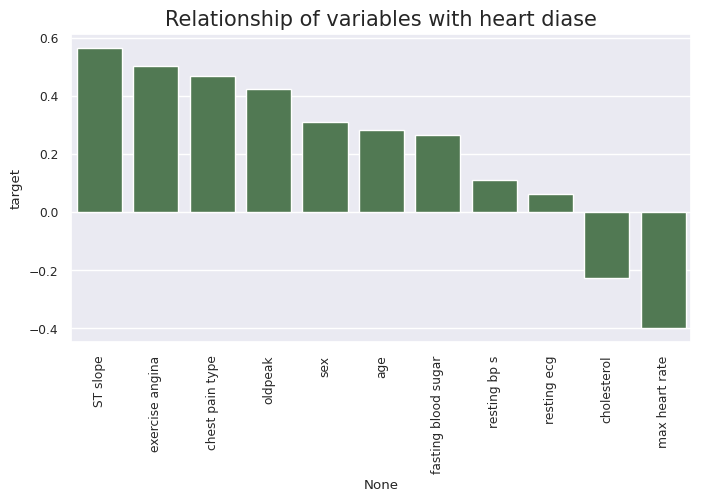

In [19]:
#various graphs
plt.figure(figsize=(8,4))
sns.set(font_scale=0.8)
sns.barplot(x=heart_diase_corr.index, y=heart_diase_corr, color="#4a804d")
plt.xticks(rotation=90)
plt.title("Relationship of variables with heart diase", fontsize=15)
plt.show()


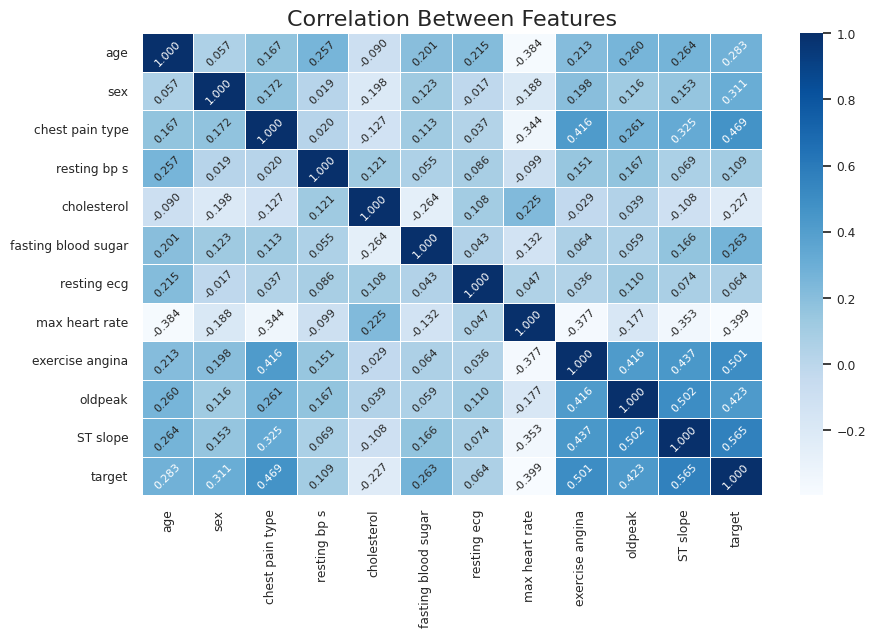

In [20]:
#correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, linewidths=0.4, fmt='.3f', cmap="Blues",
annot_kws={'size': 8, 'rotation': 45})
plt.title("Correlation Between Features", fontsize=16)
plt.show()


In [21]:
#feature selection
df = pd.get_dummies(data=df, columns=["chest pain type", "resting ecg", "ST slope"])

In [22]:
#splitting data and training
y = df["target"]
X = df.drop("target", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,
random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]= scaler.transform(X_test[num_cols])

In [23]:
#checking accuracy with various other algorithm
model_list = [LinearSVC(), LogisticRegression(), GradientBoostingClassifier(),
              MLPClassifier(max_iter=2000), AdaBoostClassifier(),
              HistGradientBoostingClassifier(),
              SVC(), XGBClassifier(), CatBoostClassifier(verbose=False)]
model_name_list = []
accuracy_list = []
for model_name in model_list:
 model = model_name
 model_cv = cross_val_score(model,
 X_train,
 y_train,
 cv=10,
 scoring= "accuracy",
 n_jobs=-1)
 model_name_list.append(model_name.__class__.__name__)
 accuracy_list.append(model_cv.mean())
 print(f"{model_name.__class__.__name__} cross validation score: {model_cv.mean()}")
 print("-" * 50)


LinearSVC cross validation score: 0.8547371031746032
--------------------------------------------------
LogisticRegression cross validation score: 0.8515873015873016
--------------------------------------------------
GradientBoostingClassifier cross validation score: 0.8531498015873016
--------------------------------------------------
MLPClassifier cross validation score: 0.8262152777777777
--------------------------------------------------
AdaBoostClassifier cross validation score: 0.8373015873015873
--------------------------------------------------
HistGradientBoostingClassifier cross validation score: 0.8625992063492063
--------------------------------------------------
SVC cross validation score: 0.8531001984126985
--------------------------------------------------
XGBClassifier cross validation score: 0.8420138888888887
--------------------------------------------------
CatBoostClassifier cross validation score: 0.859375
--------------------------------------------------


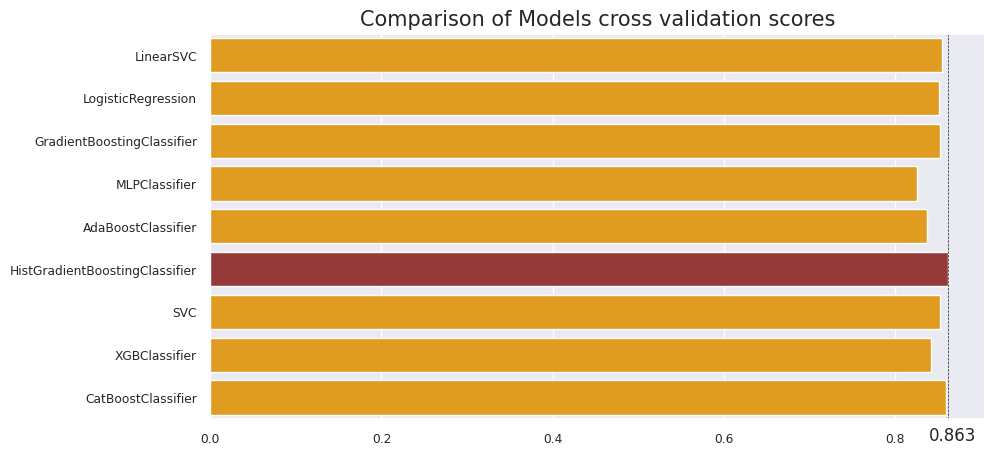

In [24]:
#graphical representation of accuracy of various individual algorithm
plt.figure(figsize=(10,5))
clrs = ["brown" if i == max(accuracy_list) else "orange" for i in accuracy_list]
sns.barplot(x=accuracy_list, y=model_name_list, palette=clrs)
plt.axvline(0.8626, ls="--", lw=0.5, color="k")
plt.text(0.84,9, s="0.863", fontsize=12)
plt.title("Comparison of Models cross validation scores", fontsize=15)
plt.show()

In [25]:
#proposed hybrid model
gb_1 = GradientBoostingClassifier(**{"max_depth": 2,
 "min_samples_split": 5,
 "min_samples_leaf": 4,
 "learning_rate": 0.0448191306552163,
 "n_estimators": 110})
catb_2 = CatBoostClassifier(**{"depth": 6,
 "l2_leaf_reg": 8,
 "random_strength": 4,
 "subsample": 0.8263,
 "verbose": False})
voting = VotingClassifier(estimators= [("GBoosting", gb_1),
 ("CatBoost", catb_2)],
 voting="hard",
 n_jobs=-1)
voting_fit = voting.fit(X_train, y_train)

In [26]:
#choosing out ml algorithm for of proposed model
accuracy_list = []
for clf in (gb_1, catb_2, voting_fit):
 clf.fit(X_train, y_train)
 y_pred = clf.predict(X_test)
 acc = accuracy_score(y_test, y_pred)
 accuracy_list.append(acc)
 print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

GradientBoostingClassifier 0.9007352941176471
CatBoostClassifier 0.8970588235294118
VotingClassifier 0.9044117647058824


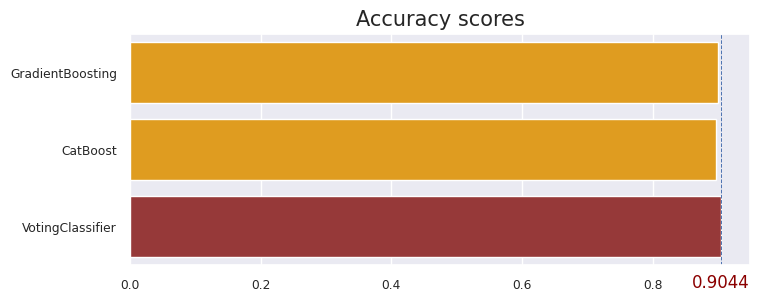

In [27]:
#comparing accuracy
selected_models = ["GradientBoosting", "CatBoost", "VotingClassifier"]
plt.figure(figsize=(8,3))
clrs = ["brown" if i == max(accuracy_list) else "orange" for i in accuracy_list]
sns.barplot(x=accuracy_list, y=selected_models, palette=clrs)
plt.axvline(0.9044, ls="--", lw=0.7, color="b")
plt.text(0.86,2.80, s="0.9044", fontsize=12, color="darkred")
plt.title("Accuracy scores", fontsize=15)
plt.show()

In [28]:
#accrucy of proposed model
y_pred_voting = voting_fit.predict(X_test)
print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       122
           1       0.94      0.88      0.91       150

    accuracy                           0.90       272
   macro avg       0.90      0.91      0.90       272
weighted avg       0.91      0.90      0.90       272



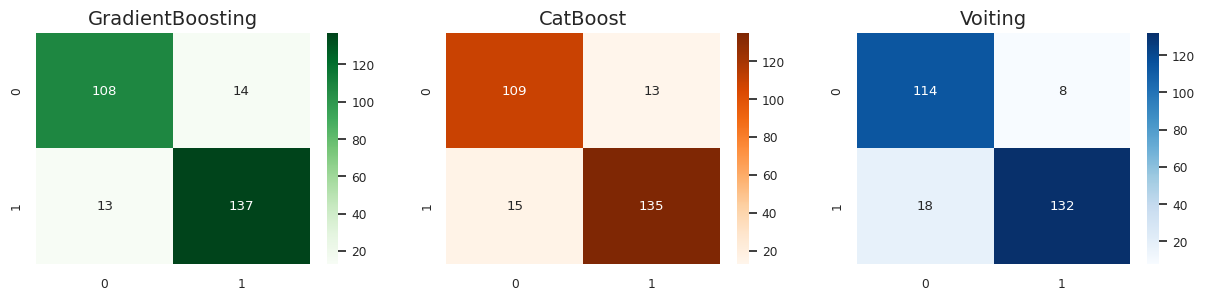

In [29]:
pred_gb = gb_1.predict(X_test)
GBoosting_cm = confusion_matrix(y_test, pred_gb)
pred_catb = catb_2.predict(X_test)
CatBoost_cm = confusion_matrix(y_test, pred_catb)
Voting_cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(15, 3))
plt.subplot(1,3,1)
sns.heatmap(GBoosting_cm, annot=True, fmt="g", cmap="Greens")
plt.title("GradientBoosting", fontsize=14)
plt.subplot(1,3,2)
sns.heatmap(CatBoost_cm, annot=True, fmt="g", cmap="Oranges")
plt.title("CatBoost", fontsize=14)
plt.subplot(1,3,3)
sns.heatmap(Voting_cm, annot=True, fmt="g", cmap="Blues")
plt.title("Voiting", fontsize=14)
plt.show()